# Projeto 2 de Ciência dos Dados - Predição de crimes em São Francisco

#### Turma 2B
Rafael Kahn<br>
Hélio Zaia<br>
Gabriel Parfan<br>

## Introdução

Este projeto tem por objetivo fazer uma analise estatistica dos crimes que ocorrem na cidade de São Francisco, tendo por base um DataFrame obtido do site  kaggle; Com base nesses dados deu-se início à analise estatistica buscando criar um algoritimo capaz de classificar um determinado crime com base no horario, distrito, bairro, dia da semana e localização geográfica. Já é de senso comum da população ao redor do mundo de que certas variáveis citadas anteriormente influenciam na possibilidade de algum tipo de crime acontecer, porém quanto essas variáveis realmente influenciam na possibilidade de um crime acontecer? Este trabalho pretende analisar essa influência e descobrir se é possível classificar que tipo de crime aconteceria dadas as circunstâncias mencionadas.

## Objetivo

O objetivo deste trabalho é responder a pergunta: Como pode-se classificar o crime que aconteceria dadas certas variáveis?

## Preparo do dataset

In [1]:
#Bibliotecas
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn
from scipy.stats import norm, uniform, probplot
from sklearn import svm, datasets
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import export_graphviz
import graphviz

In [2]:
#Definindo seed
RANDOM_SEED = 13
np.random.seed(RANDOM_SEED)

In [3]:
#função para gerar crosstabs com a correlação entre valores escolhidos
def corrtab_data(data):
        k = [np.corrcoef(data.loc[data.index[a],:],range(0,len(data.columns)))[0,1] for a in range(len(data.index))]
        dic = dict(zip(data.index,k))
        return dic

In [4]:
#Abrindo o dataset
data = pd.read_csv("Crimes_SF.csv")
data.head(10)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,120058272,WEAPON LAWS,POSS OF PROHIBITED WEAPON,Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212120
1,120058272,WEAPON LAWS,"FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE",Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212168
2,141059263,WARRANTS,WARRANT ARREST,Monday,04/25/2016 12:00:00 AM,14:59,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,-122.388856,37.729981,"(37.7299809672996, -122.388856204292)",14105926363010
3,160013662,NON-CRIMINAL,LOST PROPERTY,Tuesday,01/05/2016 12:00:00 AM,23:50,TENDERLOIN,NONE,JONES ST / OFARRELL ST,-122.412971,37.785788,"(37.7857883766888, -122.412970537591)",16001366271000
4,160002740,NON-CRIMINAL,LOST PROPERTY,Friday,01/01/2016 12:00:00 AM,00:30,MISSION,NONE,16TH ST / MISSION ST,-122.419672,37.765050,"(37.7650501214668, -122.419671780296)",16000274071000
5,160002869,ASSAULT,BATTERY,Friday,01/01/2016 12:00:00 AM,21:35,NORTHERN,NONE,1700 Block of BUSH ST,-122.426077,37.788019,"(37.788018555829, -122.426077177375)",16000286904134
6,160003130,OTHER OFFENSES,PAROLE VIOLATION,Saturday,01/02/2016 12:00:00 AM,00:04,SOUTHERN,"ARREST, BOOKED",MARY ST / HOWARD ST,-122.405721,37.780879,"(37.7808789360214, -122.405721454567)",16000313026150
7,160003259,NON-CRIMINAL,FIRE REPORT,Saturday,01/02/2016 12:00:00 AM,01:02,TENDERLOIN,NONE,200 Block of EDDY ST,-122.411778,37.783981,"(37.7839805592634, -122.411778295992)",16000325968000
8,160003970,WARRANTS,WARRANT ARREST,Saturday,01/02/2016 12:00:00 AM,12:21,SOUTHERN,"ARREST, BOOKED",4TH ST / BERRY ST,-122.393357,37.775788,"(37.7757876218293, -122.393357241451)",16000397063010
9,160003641,MISSING PERSON,FOUND PERSON,Friday,01/01/2016 12:00:00 AM,10:06,BAYVIEW,NONE,100 Block of CAMERON WY,-122.387182,37.720967,"(37.7209669615499, -122.387181635995)",16000364175000


In [34]:
#Conferindo as classes do dataset
data.Category.value_counts()

LARCENY/THEFT                  40409
OTHER OFFENSES                 19599
NON-CRIMINAL                   17866
ASSAULT                        13577
VANDALISM                       8589
VEHICLE THEFT                   6419
WARRANTS                        5914
BURGLARY                        5802
SUSPICIOUS OCC                  5782
MISSING PERSON                  4338
DRUG/NARCOTIC                   4243
ROBBERY                         3299
FRAUD                           2635
SECONDARY CODES                 1841
TRESPASS                        1812
WEAPON LAWS                     1658
SEX OFFENSES, FORCIBLE           940
STOLEN PROPERTY                  882
RECOVERED VEHICLE                736
DISORDERLY CONDUCT               658
PROSTITUTION                     641
FORGERY/COUNTERFEITING           619
DRUNKENNESS                      465
DRIVING UNDER THE INFLUENCE      378
ARSON                            286
KIDNAPPING                       257
EMBEZZLEMENT                     168
L

In [6]:
#Limpeza Inicial
#Deixando apenas os crimes mais relevantes (inicialmente 4)
data_f = data[(data['Category'] == 'LARCENY/THEFT') | (data['Category'] == 'ASSAULT') | (data['Category'] == 'OTHER OFFENSES') | (data['Category'] == 'VEHICLE THEFT')]
data_f.head(5)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
5,160002869,ASSAULT,BATTERY,Friday,01/01/2016 12:00:00 AM,21:35,NORTHERN,NONE,1700 Block of BUSH ST,-122.426077,37.788019,"(37.788018555829, -122.426077177375)",16000286904134
6,160003130,OTHER OFFENSES,PAROLE VIOLATION,Saturday,01/02/2016 12:00:00 AM,00:04,SOUTHERN,"ARREST, BOOKED",MARY ST / HOWARD ST,-122.405721,37.780879,"(37.7808789360214, -122.405721454567)",16000313026150
10,160086863,LARCENY/THEFT,ATTEMPTED THEFT FROM LOCKED VEHICLE,Friday,01/29/2016 12:00:00 AM,22:30,TARAVAL,NONE,1200 Block of 19TH AV,-122.477377,37.764478,"(37.7644781578695, -122.477376524003)",16008686306240
12,160073014,OTHER OFFENSES,RESISTING ARREST,Monday,01/25/2016 12:00:00 AM,23:20,BAYVIEW,"ARREST, BOOKED",200 Block of HUNTERSPOINT BL,-122.376758,37.735697,"(37.7356970275482, -122.37675765553)",16007301427170
13,140776777,ASSAULT,AGGRAVATED ASSAULT WITH A GUN,Thursday,09/15/2016 12:00:00 AM,07:40,INGLESIDE,"ARREST, BOOKED",SILVER AV / CAMELLIA AV,-122.432326,37.729271,"(37.7292705199592, -122.432325871028)",14077677704011


## Análise Exploratória


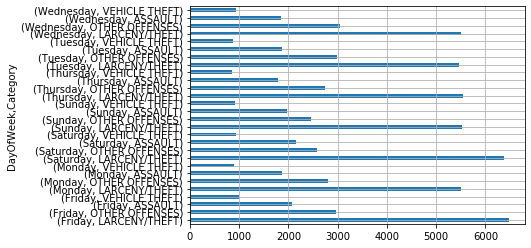

In [7]:
#Gráfico mostrando a quantidade de crimes por dia da semana
data_f.groupby('DayOfWeek').Category.value_counts().plot.barh()
plt.style.use("ggplot")
plt.grid(True)

In [8]:
#Tabela de relação entre os dias da semana e os tipos de crime
tabela_ds = pd.crosstab(data_f.Category, data_f.DayOfWeek, normalize = 'index')
tabela_ds

DayOfWeek,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Category,,,,,,,
ASSAULT,0.153348,0.137365,0.158872,0.144804,0.131251,0.137954,0.136407
LARCENY/THEFT,0.160286,0.136183,0.157985,0.136875,0.137049,0.135440,0.136183
OTHER OFFENSES,0.151742,0.143171,0.131792,0.125261,0.140415,0.152457,0.155161
VEHICLE THEFT,0.155632,0.140676,0.145817,0.142546,0.133354,0.137249,0.144727


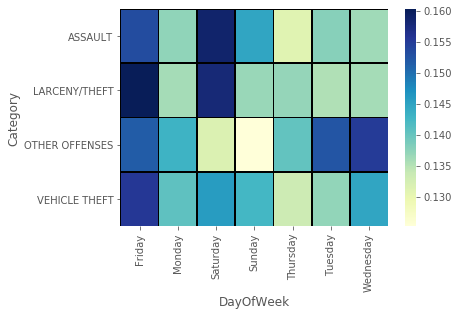

In [35]:
#Heatmap da tabela entre dias da semana e tipos de crime
seaborn.heatmap(tabela_ds, annot = False, fmt = 'd',linecolor="blacK",linewidth=.5,cmap='YlGnBu');

* Como podemos observar pelo gráfico acima, o dia da semana não possui uma alta influência sobre os crimes que ocorrem na cidade de São Francisco

In [10]:
#horario = tabela_ho.columns  

data_f["Hour"] = data_f.Time.str.slice(0,3) + "00"
    
data_f["Hour"].value_counts()
tabela_Category_Time = pd.crosstab(data_f.Category, data_f.Hour, normalize='index')
tabela_Category_Time

C:\Users\lobda\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hour,00:00,01:00,02:00,03:00,04:00,05:00,06:00,07:00,08:00,09:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
Category,,,,,,,,,,,,,,,,,,,,,
ASSAULT,0.048612,0.043088,0.039552,0.023348,0.015025,0.010533,0.017603,0.026074,0.033365,0.036385,...,0.046991,0.055903,0.055535,0.058039,0.051779,0.051337,0.054651,0.059070,0.048538,0.046476
LARCENY/THEFT,0.034423,0.025415,0.016110,0.009676,0.006682,0.007449,0.010913,0.015318,0.027073,0.032196,...,0.053948,0.054122,0.058626,0.068772,0.080477,0.080304,0.070009,0.056374,0.047588,0.042812
OTHER OFFENSES,0.067912,0.029338,0.023215,0.018981,0.013470,0.009439,0.012858,0.027042,0.042298,0.042298,...,0.049798,0.057605,0.059646,0.063371,0.056023,0.047758,0.040308,0.038471,0.046533,0.045564
VEHICLE THEFT,0.034585,0.026328,0.016669,0.011061,0.008880,0.010438,0.019629,0.025705,0.033339,0.034429,...,0.037701,0.040972,0.052656,0.073064,0.083969,0.073687,0.080542,0.072597,0.076803,0.062627


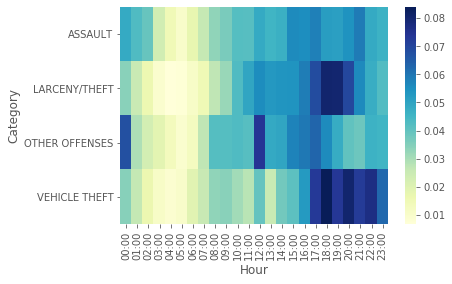

In [36]:
#Heatmap entre as horas do dia e o tipo de crime
seaborn.heatmap(tabela_Category_Time, annot = False, fmt = 'd', cmap='YlGnBu');

In [37]:
#Obtendo a correlação entre as variáveis
Corr_Category_Hour = corrtab_data(tabela_Category_Time)
tabela_Corr_Category_Hour = pd.DataFrame([Corr_Category_Hour])
tabela_Corr_Category_Hour

,ASSAULT,LARCENY/THEFT,OTHER OFFENSES,VEHICLE THEFT
0,0.657891,0.785558,0.466086,0.862514


* Com as informações plotadas no gráfico acima, podemos perceber que a hora tem uma grande influência na ocorrência de crimes e seus tipos. Como pode-se observar, a grande maioria dos crimes acontecem nos horários do final da tarde, e quase nunca de madrugada.

In [38]:
#Tabela entre bairros e tipo de crime
tabela_Category_District = pd.crosstab(data_f.Category, data_f.PdDistrict, normalize = 'index')
tabela_Category_District

PdDistrict,0,1,2,3,4,5,6,7,8,9
Category,,,,,,,,,,
0,0.130736,0.087427,0.110923,0.155410,0.113133,0.038595,0.034838,0.173234,0.067614,0.088090
1,0.058330,0.166799,0.044075,0.082187,0.178653,0.055039,0.077534,0.227752,0.064467,0.045164
2,0.120057,0.088627,0.095260,0.152559,0.113220,0.055462,0.052146,0.170213,0.089341,0.063115
3,0.168406,0.074934,0.142546,0.145194,0.115127,0.070416,0.080231,0.095498,0.083814,0.023835


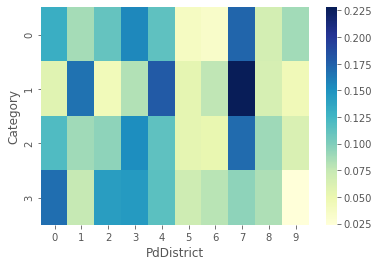

In [39]:
#Heatmap dos bairros com tipo de crime
seaborn.heatmap(tabela_Category_District, annot = False, fmt = 'd', cmap='YlGnBu');

* O gráfico acima nos mostra quem existem bairros mais perigosos do que outros em São Francisco. É possível afirmar que bairros como Park, Richmond, Taraval e Tenderloin são bairros menos violentos e propícios à crimes.

In [40]:
#Tabela entre as horas dos crimes e os bairros
tabela_Hour_District = pd.crosstab(data_f.PdDistrict, data_f.Hour, normalize = 'index')
tabela_Hour_District

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
PdDistrict,,,,,,,,,,,,,,,,,,,,,
0,0.045467,0.024451,0.017843,0.016257,0.013349,0.010177,0.017314,0.024319,0.044277,0.037801,...,0.043087,0.043748,0.053132,0.061195,0.074015,0.070975,0.061856,0.059741,0.051811,0.048242
1,0.039034,0.024051,0.022770,0.011434,0.006407,0.008280,0.009266,0.017053,0.027896,0.034993,...,0.058255,0.055495,0.060030,0.070478,0.076589,0.069492,0.066437,0.053031,0.048595,0.037654
2,0.054704,0.032625,0.022574,0.017960,0.011699,0.011040,0.013511,0.022244,0.035261,0.039545,...,0.043829,0.051244,0.053386,0.060636,0.063272,0.063602,0.062613,0.061130,0.057176,0.052727
3,0.054100,0.043302,0.029082,0.021170,0.013365,0.008874,0.016893,0.022025,0.032503,0.034748,...,0.045761,0.050786,0.053352,0.063402,0.064364,0.056880,0.057415,0.051641,0.058056,0.054635
4,0.041919,0.034150,0.022624,0.017075,0.010843,0.007513,0.013831,0.017929,0.032699,0.036114,...,0.047127,0.052335,0.055665,0.062495,0.071886,0.071288,0.065910,0.053103,0.049688,0.048579
5,0.029858,0.025659,0.018428,0.008631,0.011430,0.006765,0.015395,0.024259,0.033357,0.039655,...,0.050618,0.056916,0.065780,0.066247,0.061582,0.060182,0.059249,0.054817,0.048985,0.042454
6,0.039860,0.018083,0.016138,0.005833,0.007389,0.006805,0.007972,0.015555,0.028388,0.030916,...,0.061637,0.064748,0.058526,0.069998,0.072720,0.070970,0.060859,0.052304,0.040832,0.031694
7,0.048439,0.028767,0.022575,0.011287,0.007998,0.007224,0.011868,0.021736,0.027864,0.033540,...,0.051600,0.056566,0.060823,0.071788,0.070949,0.070627,0.057340,0.050890,0.047794,0.047601
8,0.046800,0.025120,0.015141,0.013765,0.009635,0.008087,0.011700,0.022368,0.036476,0.036992,...,0.055058,0.055231,0.053338,0.060392,0.065382,0.069683,0.065210,0.057811,0.051961,0.044219


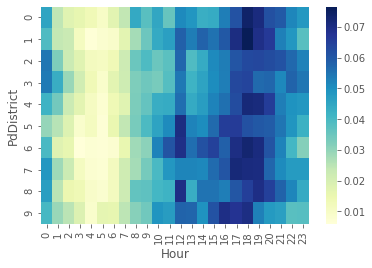

In [41]:
#Heatmap entre as horas dos crimes e os bairros
seaborn.heatmap(tabela_Hour_District, annot = False, fmt = 'd', cmap='YlGnBu');

In [42]:
#Obtendo a correlação entre variáveis
orr_Hour_District = corrtab_data(tabela_Hour_District)

tabela_Corr_Hour_District = pd.DataFrame([Corr_Hour_District])
tabela_Corr_Hour_District

,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
0,0.787455,0.745778,0.757947,0.702664,0.767471,0.769941,0.678071,0.734609,0.755545,0.63442


In [44]:
#tabela entre dia da semana e hora dos crimes
tabela_DayOfWeek_Hour = pd.crosstab(data_f.DayOfWeek, data_f.Hour, normalize = 'index')
tabela_DayOfWeek_Hour

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
DayOfWeek,,,,,,,,,,,,,,,,,,,,,
0,0.043808,0.024896,0.018034,0.012448,0.008379,0.008538,0.014283,0.024098,0.028567,0.035429,...,0.046521,0.051309,0.057852,0.064874,0.069263,0.065911,0.062241,0.057932,0.053623,0.060246
1,0.041347,0.024375,0.019590,0.015167,0.010472,0.009750,0.016069,0.021035,0.037284,0.039271,...,0.050104,0.057597,0.060486,0.071138,0.072944,0.066444,0.062201,0.051007,0.043784,0.037916
2,0.051741,0.041459,0.028690,0.018076,0.010365,0.009370,0.008624,0.016003,0.024876,0.028524,...,0.052156,0.052405,0.055473,0.056716,0.063847,0.057629,0.058955,0.058458,0.056136,0.061857
3,0.056599,0.050525,0.037824,0.017210,0.010215,0.007546,0.011780,0.017118,0.025584,0.032763,...,0.049696,0.055586,0.056138,0.064881,0.061292,0.062212,0.055862,0.046935,0.050064,0.037732
4,0.043466,0.020315,0.016105,0.012262,0.010981,0.008327,0.013635,0.020955,0.035597,0.040081,...,0.053807,0.053898,0.056918,0.065154,0.071925,0.072200,0.060853,0.054173,0.051428,0.041270
5,0.039144,0.023897,0.017566,0.013553,0.009897,0.008917,0.012840,0.023629,0.035845,0.035488,...,0.053500,0.051538,0.060366,0.067677,0.072581,0.073473,0.066251,0.053321,0.047347,0.037004
6,0.039205,0.020751,0.015629,0.012009,0.009448,0.008389,0.015541,0.022958,0.039735,0.037969,...,0.047770,0.057748,0.058013,0.072141,0.077704,0.071082,0.060309,0.053333,0.045563,0.040442


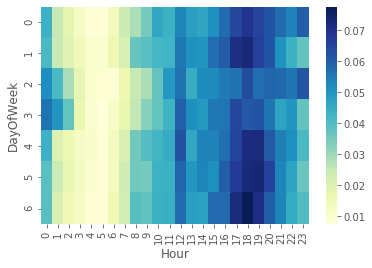

In [45]:
#Heatmap entre os dias da semana e a hora dos crimes
seaborn.heatmap(tabela_DayOfWeek_Hour, annot = False, fmt = 'd', cmap='YlGnBu');

In [46]:
#Obtendo a correlação entre as variáveis
Corr_DayOfWeek_Hour = corrtab_data(tabela_DayOfWeek_Hour)

tabela_Corr_DayOfWeek_Hour = pd.DataFrame([Corr_DayOfWeek_Hour])
tabela_Corr_DayOfWeek_Hour

,0,1,2,3,4,5,6
0,0.836512,0.731121,0.734373,0.537768,0.765946,0.755492,0.757657


In [48]:
#Tabela entre dia das semanas e bairros
tabela_DayOfWeek_District =  pd.crosstab(data_f.DayOfWeek, data_f.PdDistrict, normalize = 'index')
tabela_DayOfWeek_District 

PdDistrict,0,1,2,3,4,5,6,7,8,9
DayOfWeek,,,,,,,,,,
0,0.092802,0.130705,0.077162,0.109560,0.147782,0.053862,0.067986,0.197095,0.070061,0.052984
1,0.097409,0.128916,0.077999,0.114291,0.145888,0.055701,0.066083,0.186513,0.071770,0.055430
2,0.085240,0.138557,0.071061,0.113765,0.153483,0.051575,0.061028,0.207463,0.065174,0.052653
3,0.091846,0.128658,0.071047,0.123597,0.149733,0.050525,0.060464,0.198785,0.068839,0.056507
4,0.103679,0.117039,0.074671,0.117862,0.143393,0.050970,0.067990,0.195827,0.077965,0.050604
5,0.095140,0.122960,0.080963,0.123406,0.142042,0.056442,0.060544,0.180562,0.078734,0.059206
6,0.096954,0.119382,0.078146,0.117174,0.141898,0.055982,0.065695,0.189051,0.076821,0.058896


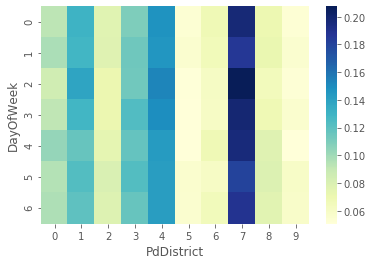

In [49]:
#Heatmap entre os dias da semana e os bairros
seaborn.heatmap(tabela_DayOfWeek_District, annot = False, fmt = 'd', cmap='YlGnBu');

## Classificador

In [23]:
data_f = data_f.drop('Date', 1)
data_f = data_f.drop('Location', 1)

In [24]:
#Obtendo frequência relativa das categorias
data_f.Category.value_counts(True)

LARCENY/THEFT     0.505087
OTHER OFFENSES    0.244975
ASSAULT           0.169704
VEHICLE THEFT     0.080233
Name: Category, dtype: float64

In [25]:
data_f = data_f.dropna()

In [26]:
categorical_feature_mask = data_f.dtypes==object
categorical_cols = data_f.columns[categorical_feature_mask].tolist()
le = LabelEncoder()
data_f[categorical_cols] = data_f[categorical_cols].apply(lambda col: le.fit_transform(col))
categorical_features = categorical_feature_mask
ohe = OneHotEncoder(categorical_features, sparse=False)

In [50]:
#Visualizando dataset
data_f.head()

,IncidntNum,Category,Descript,DayOfWeek,Time,PdDistrict,Resolution,Address,X,Y,PdId,Hour
5,160002869,0,37,0,1290,4,7,3145,-122.426077,37.788019,16000286904134,21
6,160003130,2,140,2,3,7,0,11811,-122.405721,37.780879,16000313026150,0
10,160086863,1,32,0,1345,8,7,2044,-122.477377,37.764478,16008686306240,22
12,160073014,2,173,1,1395,0,0,3941,-122.376758,37.735697,16007301427170,23
13,140776777,0,5,4,455,2,0,13164,-122.432326,37.729271,14077677704011,7


In [29]:
x = data_f[['DayOfWeek', 'Hour', 'PdDistrict', 'Address', 'X', 'Y', 'PdId']]
y = data_f['Category']

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=152)

In [31]:
model = RandomForestClassifier(n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('Acurácia: {:.3f} %'.format(accuracy_score(y_test, y_pred)*100))

Acurácia: 63.118 %


In [51]:
#plotando uma matriz de confusão
matriz = pd.crosstab(y_test, y_pred, normalize = 'index')
matriz

col_0,0,1,2,3
Category,,,,
0,0.413851,0.253378,0.308880,0.023890
1,0.063203,0.805510,0.115321,0.015966
2,0.155818,0.250299,0.559542,0.034341
3,0.124739,0.276096,0.378914,0.220251


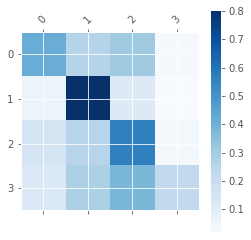

In [52]:
#Criando o gráfico da matriz de confusão
def plot_confusion_matrix(df_confusion, cmap=plt.cm.Blues):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)

#Plotando o gráfico
plot_confusion_matrix(matriz)

## Conclusão

## Fontes:

https://towardsdatascience.com/encoding-categorical-features-21a2651a065c<br>
https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn<br>
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py<br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html